In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess data
data = pd.read_csv('personality_dataset.csv')

# Verify required columns
required_columns = ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance', 'Going_outside', 
                    'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency', 'Personality']
if not all(col in data.columns for col in required_columns):
    raise ValueError("Missing required columns in dataset")

# Define columns
numeric_columns = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 
                  'Friends_circle_size', 'Post_frequency']
categorical_columns = ['Stage_fear', 'Drained_after_socializing']
target_column = 'Personality'

In [15]:
# Verify categorical values
for col in categorical_columns:
    print(f"\nUnique values in {col}:")
    print(data[col].value_counts(dropna=False))


Unique values in Stage_fear:
Stage_fear
No     1417
Yes    1410
NaN      73
Name: count, dtype: int64

Unique values in Drained_after_socializing:
Drained_after_socializing
No     1441
Yes    1407
NaN      52
Name: count, dtype: int64


In [16]:
# Display basic information
print("Dataset Shape:", data.shape)
print("\nDataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Shape: (2900, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB
None

Missing Values:
Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency            

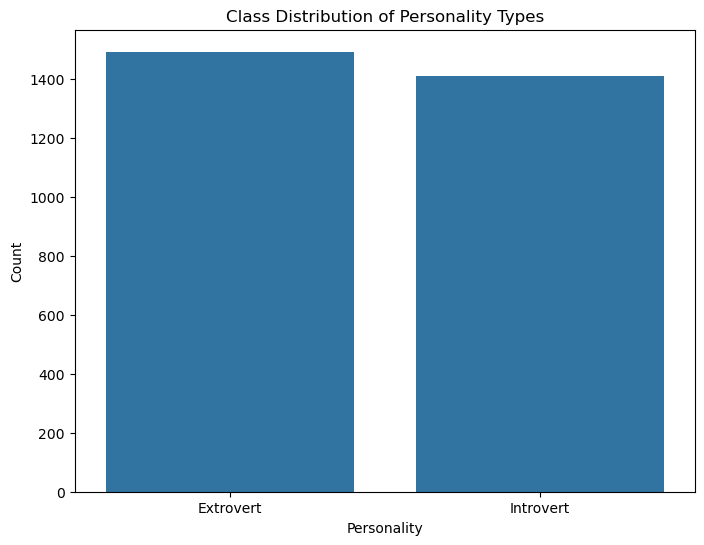

In [17]:
# Class distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.countplot(x=target_column, data=data)
plt.title('Class Distribution of Personality Types')
plt.xlabel('Personality')
plt.ylabel('Count')
plt.show()

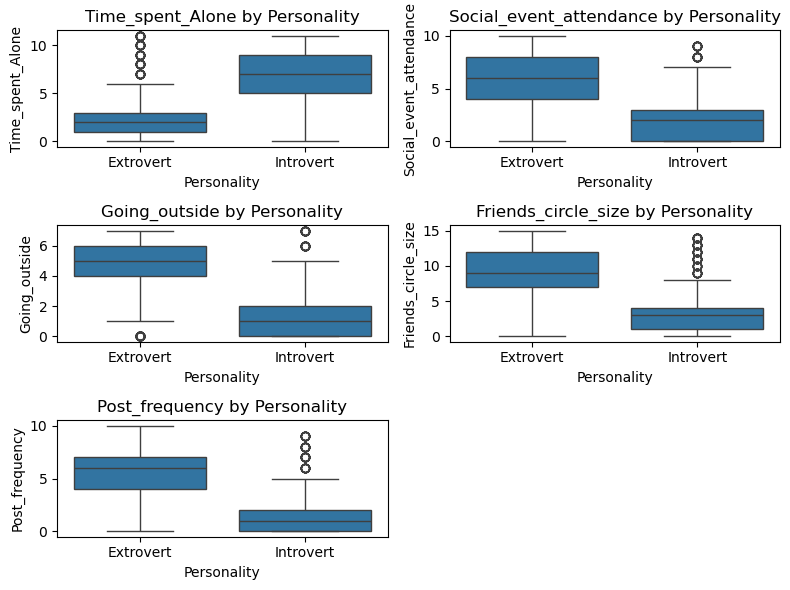

In [18]:
plt.figure(figsize=(8, 6))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=target_column, y=col, data=data)
    plt.title(f'{col} by Personality')
plt.tight_layout()
plt.show()

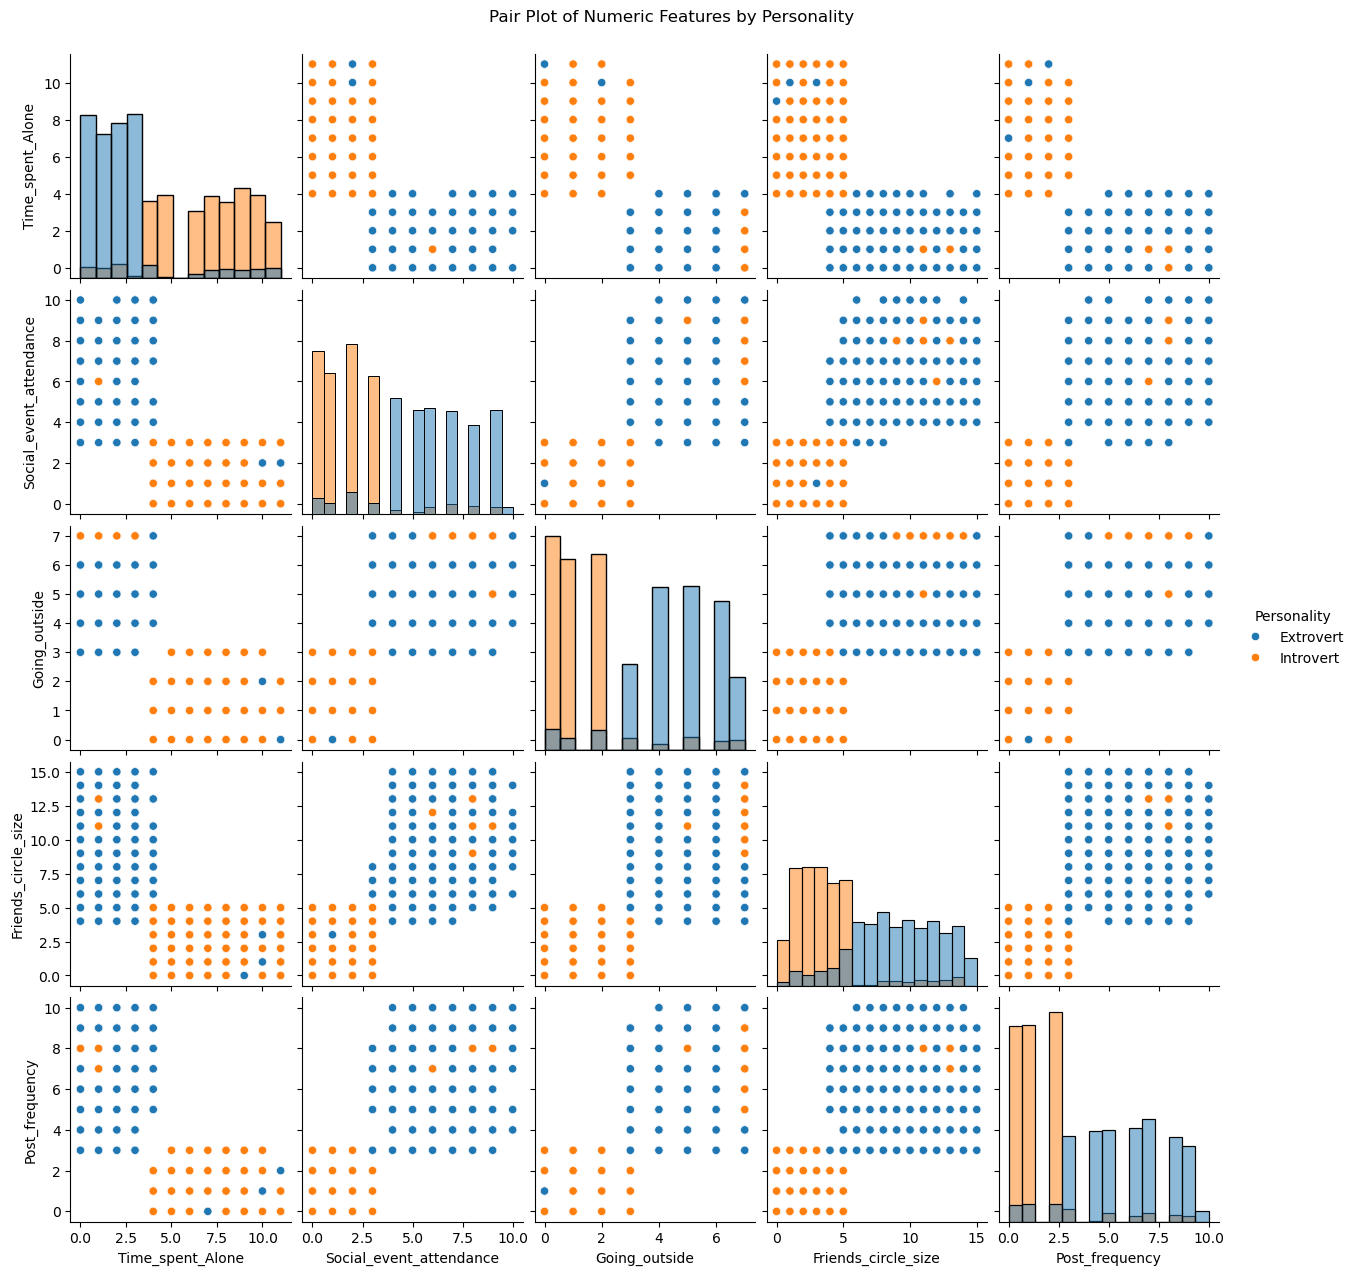

In [19]:
sns.pairplot(data[numeric_columns + [target_column]], hue=target_column, diag_kind='hist')
plt.suptitle('Pair Plot of Numeric Features by Personality', y=1.02)
plt.show()

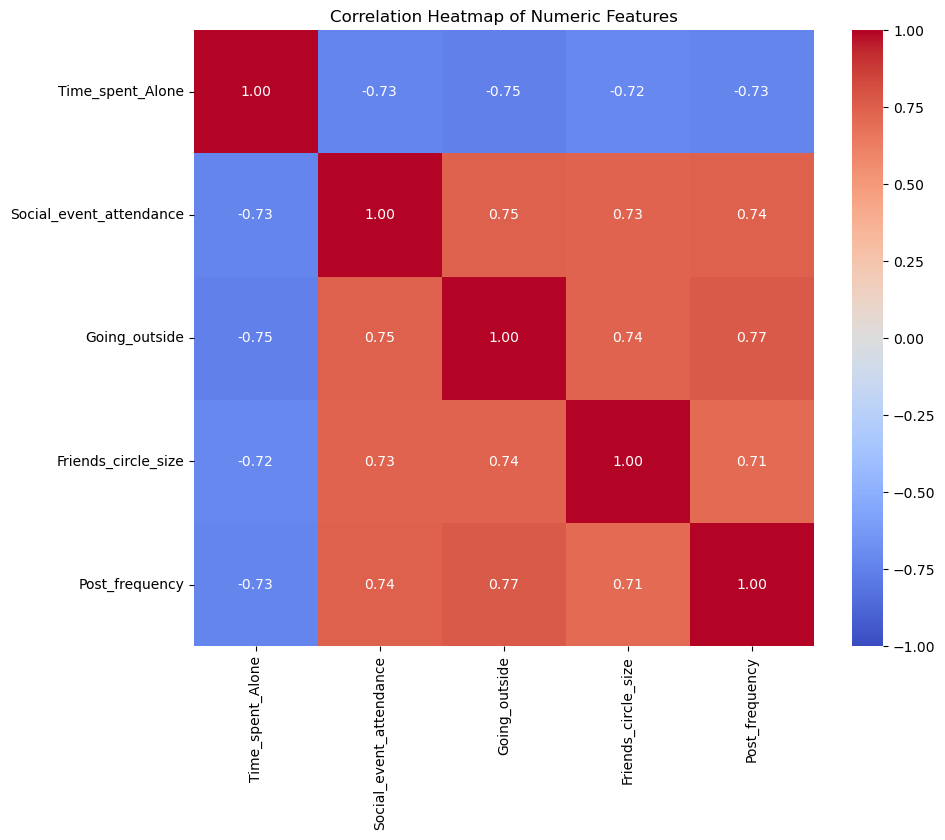

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(data[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [21]:
# Encode target variable
le = LabelEncoder()
data[target_column] = le.fit_transform(data[target_column])  # Extrovert=1, Introvert=0

# Handle missing values
numeric_imputer = SimpleImputer(strategy='median')
data[numeric_columns] = numeric_imputer.fit_transform(data[numeric_columns])
categorical_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_columns] = categorical_imputer.fit_transform(data[categorical_columns])

# Encode categorical features
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Cap outliers (less aggressive for extrovert-indicating features)
for col in numeric_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    # Less aggressive upper bound for extrovert-related features
    upper_bound = Q3 + 2.5 * IQR if col in ['Social_event_attendance', 'Friends_circle_size', 'Post_frequency'] else Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Compute bins for Time_spent_Alone
time_alone_bins = pd.qcut(data['Time_spent_Alone'], q=3, retbins=True)[1]

# Train-test split
X = data.drop(columns=[target_column])
y = data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [22]:
# Feature engineering
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Interaction features
X_train['Alone_to_Social_Ratio'] = X_train['Time_spent_Alone'] / (X_train['Social_event_attendance'] + 1)
X_test['Alone_to_Social_Ratio'] = X_test['Time_spent_Alone'] / (X_test['Social_event_attendance'] + 1)
X_train['Social_Comfort_Index'] = (X_train['Friends_circle_size'] + X_train['Post_frequency'] - X_train['Stage_fear_Yes']) / 3
X_test['Social_Comfort_Index'] = (X_test['Friends_circle_size'] + X_test['Post_frequency'] - X_test['Stage_fear_Yes']) / 3
X_train['Social_Overload'] = X_train['Drained_after_socializing_Yes'] * X_train['Social_event_attendance']
X_test['Social_Overload'] = X_test['Drained_after_socializing_Yes'] * X_test['Social_event_attendance']

# Binned features
X_train['Time_spent_Alone_Binned'] = pd.cut(X_train['Time_spent_Alone'], bins=time_alone_bins, labels=['Low', 'Medium', 'High'], include_lowest=True)
X_test['Time_spent_Alone_Binned'] = pd.cut(X_test['Time_spent_Alone'], bins=time_alone_bins, labels=['Low', 'Medium', 'High'], include_lowest=True)
X_train = pd.get_dummies(X_train, columns=['Time_spent_Alone_Binned'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Time_spent_Alone_Binned'], drop_first=True)

# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly_features_train = poly.fit_transform(X_train[['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size']])
poly_features_test = poly.transform(X_test[['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size']])
poly_feature_names = poly.get_feature_names_out(['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size'])
X_train[poly_feature_names] = poly_features_train
X_test[poly_feature_names] = poly_features_test

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [23]:
# Train RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [25]:
# Evaluate model
rf_y_pred = rf_model.predict(X_test_scaled)
print("Model Performance on Test Set:")
print(classification_report(y_test, rf_y_pred, target_names=['Introvert', 'Extrovert']))

Model Performance on Test Set:
              precision    recall  f1-score   support

   Introvert       0.90      0.89      0.89       298
   Extrovert       0.88      0.90      0.89       282

    accuracy                           0.89       580
   macro avg       0.89      0.89      0.89       580
weighted avg       0.89      0.89      0.89       580



In [28]:
from sklearn.linear_model import LogisticRegression
l_model = LogisticRegression(max_iter=1000,solver='lbfgs',C= 0.0006951927961775605)
l_model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.0006951927961775605, max_iter=1000)

In [29]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, l_model.predict(X_test_scaled))
print("Model Accuracy:", accuracy)

Model Accuracy: 0.9172413793103448


In [30]:
def predict_personality(input_dict):
    """
    Predict personality type (Extrovert or Introvert) based on input features.
    
    Args:
        input_dict (dict): Dictionary containing input features matching the dataset structure.
    
    Returns:
        str: Predicted personality ('Extrovert' or 'Introvert').
    """
    # Convert dict to DataFrame
    df_input = pd.DataFrame([input_dict])
    
    # Validate input
    missing_cols = [col for col in required_columns[:-1] if col not in df_input.columns]
    if missing_cols:
        raise ValueError(f"Missing required input columns: {missing_cols}")
    
    # Impute missing values
    df_input[numeric_columns] = numeric_imputer.transform(df_input[numeric_columns])
    df_input[categorical_columns] = categorical_imputer.transform(df_input[categorical_columns])
    
    # Encode categorical variables
    df_input = pd.get_dummies(df_input, columns=categorical_columns, drop_first=True)
    
    # Add missing dummy columns
    for col in ['Stage_fear_Yes', 'Drained_after_socializing_Yes']:
        if col not in df_input.columns:
            df_input[col] = 0
    
    # Cap outliers
    for col in numeric_columns:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 2.5 * IQR if col in ['Social_event_attendance', 'Friends_circle_size', 'Post_frequency'] else Q3 + 1.5 * IQR
        df_input[col] = df_input[col].clip(lower=lower_bound, upper=upper_bound)
    
    # Feature engineering
    df_input['Alone_to_Social_Ratio'] = df_input['Time_spent_Alone'] / (df_input['Social_event_attendance'] + 1)
    df_input['Social_Comfort_Index'] = (
        df_input['Friends_circle_size'] + df_input['Post_frequency'] - df_input['Stage_fear_Yes']
    ) / 3
    df_input['Social_Overload'] = df_input['Drained_after_socializing_Yes'] * df_input['Social_event_attendance']
    
    # Binned feature
    df_input['Time_spent_Alone_Binned'] = pd.cut(
        df_input['Time_spent_Alone'], 
        bins=time_alone_bins, 
        labels=['Low', 'Medium', 'High'], 
        include_lowest=True
    )
    df_input = pd.get_dummies(df_input, columns=['Time_spent_Alone_Binned'], drop_first=True)
    
    # Add missing bin columns
    for col in ['Time_spent_Alone_Binned_Medium', 'Time_spent_Alone_Binned_High']:
        if col not in df_input.columns:
            df_input[col] = 0
    
    # Polynomial features
    poly_input = poly.transform(df_input[['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size']])
    df_input[poly_feature_names] = poly_input
    
    # Ensure all training columns are present
    for col in X_train.columns:
        if col not in df_input.columns:
            df_input[col] = 0
    
    # Arrange columns in training order
    df_input = df_input[X_train.columns]
    
    # Scale
    input_scaled = scaler.transform(df_input)
    
    # Predict
    prediction = l_model.predict(input_scaled)[0]
    return 'Extrovert' if prediction == 0 else 'Introvert'


In [35]:
# Example usage
user_input = {
    'Time_spent_Alone': 11,
    'Stage_fear': 'Yes',
    'Social_event_attendance': 2,
    'Going_outside': 3,
    'Drained_after_socializing': 'Yes',
    'Friends_circle_size':4,
    'Post_frequency': 2
}
result = predict_personality(user_input)
print("Predicted Personality:", result)

Predicted Personality: Introvert


In [15]:
data.head()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,Personality,Stage_fear_Yes,Drained_after_socializing_Yes
0,4.0,4.0,6.0,13.0,5.0,0,False,False
1,9.0,0.0,0.0,0.0,3.0,1,True,True
2,9.0,1.0,2.0,5.0,2.0,1,True,True
3,0.0,6.0,7.0,14.0,8.0,0,False,False
4,3.0,9.0,4.0,8.0,5.0,0,False,False


In [37]:
import pickle
with open('model.pickle','wb') as f:
    pickle.dump(l_model,f)